# Predicting the number of pit stops

The number of pit stops and their duration have decreased with the years. In the first phase of this subproject I'll try to predict how many stops will there be in the race and later I would like to predict when yould it happen.

Bur first, some EDA...

In [127]:
from IPython.display import Image 
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif")

## EDA

### Setting up the main dataset

In [128]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "API_Requests_Results_Qualifying_Laps_PitStops.py"

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")

We should import info from the results data so that we can know the result of each driver at the end of each race. We should only take into account the drivers that ended each race. If the driver do not ends the race, they will probably have no pit stops.

In [129]:
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
PitsDF=PitsDF.drop(columns=['Unnamed: 0'])

In [130]:
PitsDF.tail(5)

,driverId,lap,stop,time,duration,season,round,raceName,Circuit.circuitId,Circuit.circuitName,Circuit.Location.country,date
5451,stroll,52,2,18:22:55,22.661,2021,22,Abu Dhabi Grand Prix,yas_marina,Yas Marina Circuit,UAE,2021-12-12
5452,perez,53,3,18:23:09,21.385,2021,22,Abu Dhabi Grand Prix,yas_marina,Yas Marina Circuit,UAE,2021-12-12
5453,mick_schumacher,52,2,18:23:42,22.070,2021,22,Abu Dhabi Grand Prix,yas_marina,Yas Marina Circuit,UAE,2021-12-12
5454,tsunoda,53,2,18:24:01,21.909,2021,22,Abu Dhabi Grand Prix,yas_marina,Yas Marina Circuit,UAE,2021-12-12
5455,gasly,54,2,18:25:56,21.920,2021,22,Abu Dhabi Grand Prix,yas_marina,Yas Marina Circuit,UAE,2021-12-12


In [4]:
#Creating Season-Round feature:
ResultsDF["Season-Round-Driver"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)+"-"+ResultsDF["Driver.driverId"].astype(str)
PitsDF["Season-Round-Driver"]=PitsDF["season"].astype(str)+"-"+PitsDF["round"].astype(str)+"-"+PitsDF["driverId"].astype(str)


In [30]:
#Left Join of the Pits DF with the Results DF
PitsExtraDF=PitsDF.merge(ResultsDF[["Season-Round-Driver","status",'Constructor.constructorId','Constructor.name',"laps"]],on="Season-Round-Driver",how="left")

In [48]:
#Top number of pits per race:
PitsExtraDF["stop"].unique()

array([1, 2, 3, 4], dtype=int64)

In [69]:
#Dividing the main df into separate ones taking into account the number of stops, to then unify them:
Pits1ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==1].rename(columns={'lap': 'Pit1_lap',"time":"Pit1_time","duration":"Pit1_duration"})
Pits2ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==2].rename(columns={'lap': 'Pit2_lap',"time":"Pit2_time","duration":"Pit2_duration"})
Pits3ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==3].rename(columns={'lap': 'Pit3_lap',"time":"Pit3_time","duration":"Pit3_duration"})
Pits4ExtraDF = PitsExtraDF[PitsExtraDF["stop"]==4].rename(columns={'lap': 'Pit4_lap',"time":"Pit4_time","duration":"Pit4_duration"})

PitsUnified=Pits1ExtraDF[['Season-Round-Driver', 'date', 'status', 'driverId', 'season','round', 'raceName', 'Circuit.circuitId', 'Circuit.circuitName',
       'Circuit.Location.country','Constructor.constructorId', 'Constructor.name', 'laps',
       'Pit1_lap', 'Pit1_time', 'Pit1_duration']]

#Unifying the separate datasets forming one dataset with one row per race and per driver
PitsUnified=PitsUnified.merge(Pits2ExtraDF[["Season-Round-Driver",'Pit2_lap', 'Pit2_time', 'Pit2_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits3ExtraDF[["Season-Round-Driver",'Pit3_lap', 'Pit3_time', 'Pit3_duration']],on="Season-Round-Driver",how="left")
PitsUnified=PitsUnified.merge(Pits4ExtraDF[["Season-Round-Driver",'Pit4_lap', 'Pit4_time', 'Pit4_duration']],on="Season-Round-Driver",how="left")

#Replacing na values of pits columns with 0
PitsUnified=PitsUnified.fillna(0)


In [101]:
#Adding the total number of pits per driver and per race
conditions = [
    (PitsUnified['Pit4_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] > 0),
    (PitsUnified['Pit4_lap'] == 0) & (PitsUnified['Pit3_lap'] == 0) & (PitsUnified['Pit2_lap'] == 0) & (PitsUnified['Pit1_lap'] > 0)
]

values = [4, 3, 2, 1]

PitsUnified['Num_Pits'] = np.select(conditions, values)

In [102]:
#Creating the feature of laps per pitstop. This tells us how many laps in average you can do between pit stops
PitsUnified["LapsbetweenPitstops"]=PitsUnified["laps"]/PitsUnified['Num_Pits']

#Pits of drivers that ended the races:
PitsUnified_Finished=PitsUnified[PitsUnified["status"]=="Finished"]

#Now we have one row per race and driver, only of the drivers who finished the race
PitsUnified_Finished.head(5)

,Season-Round-Driver,date,status,driverId,season,round,raceName,Circuit.circuitId,Circuit.circuitName,Circuit.Location.country,...,Pit2_time,Pit2_duration,Pit3_lap,Pit3_time,Pit3_duration,Pit4_lap,Pit4_time,Pit4_duration,Num_Pits,LapsbetweenPitstops
1,2012-1-ricciardo,2012-03-18,Finished,ricciardo,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,Australia,...,17:39:23,23.257,0.0,0,0,0.0,0,0,2,29.0
3,2012-1-rosberg,2012-03-18,Finished,rosberg,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,Australia,...,17:52:34,23.017,0.0,0,0,0.0,0,0,2,29.0
4,2012-1-alonso,2012-03-18,Finished,alonso,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,Australia,...,17:57:06,21.910,0.0,0,0,0.0,0,0,2,29.0
5,2012-1-kobayashi,2012-03-18,Finished,kobayashi,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,Australia,...,18:00:33,24.162,0.0,0,0,0.0,0,0,2,29.0
6,2012-1-resta,2012-03-18,Finished,resta,2012,1,Australian Grand Prix,albert_park,Albert Park Grand Prix Circuit,Australia,...,17:55:58,24.579,0.0,0,0,0.0,0,0,2,29.0


### Average numper of pit stops per circuit

Mugello circuit and Park Zandvoort are on average the circuits that have the highest number of pit stops per race

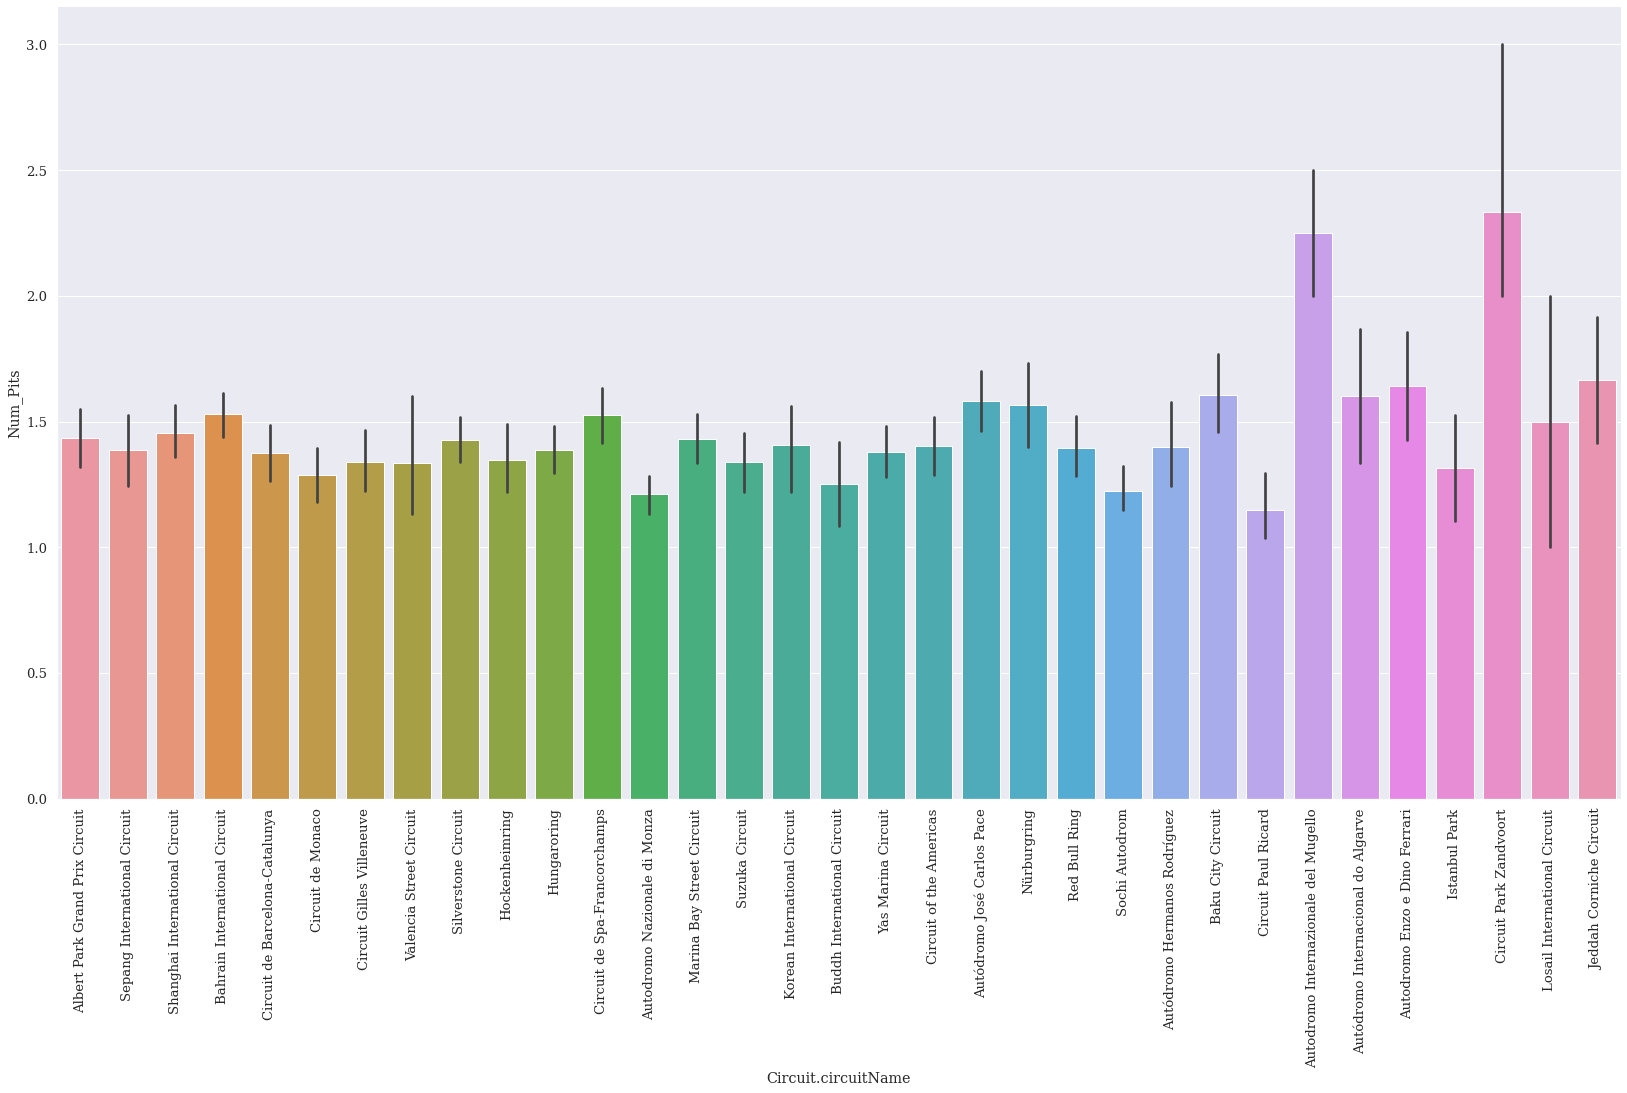

In [135]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="Circuit.circuitName", y="Num_Pits",kind="bar",height=12,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average numper of pit stops per year

The number of pit stops on average decreased in 2018. This might have been caused by several causes like changes in the regulations, different circuits in that season, etc.

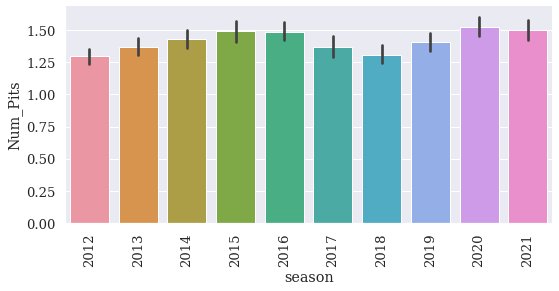

In [125]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="Num_Pits",kind="bar",height=4,aspect=2)
plt.xticks(rotation=90)
plt.show()

### Average number of laps between pit stops per circuit

We can see that contrary to what it was believed, the number of laps on average per pit stop have increased and decreased depending on each circuit.

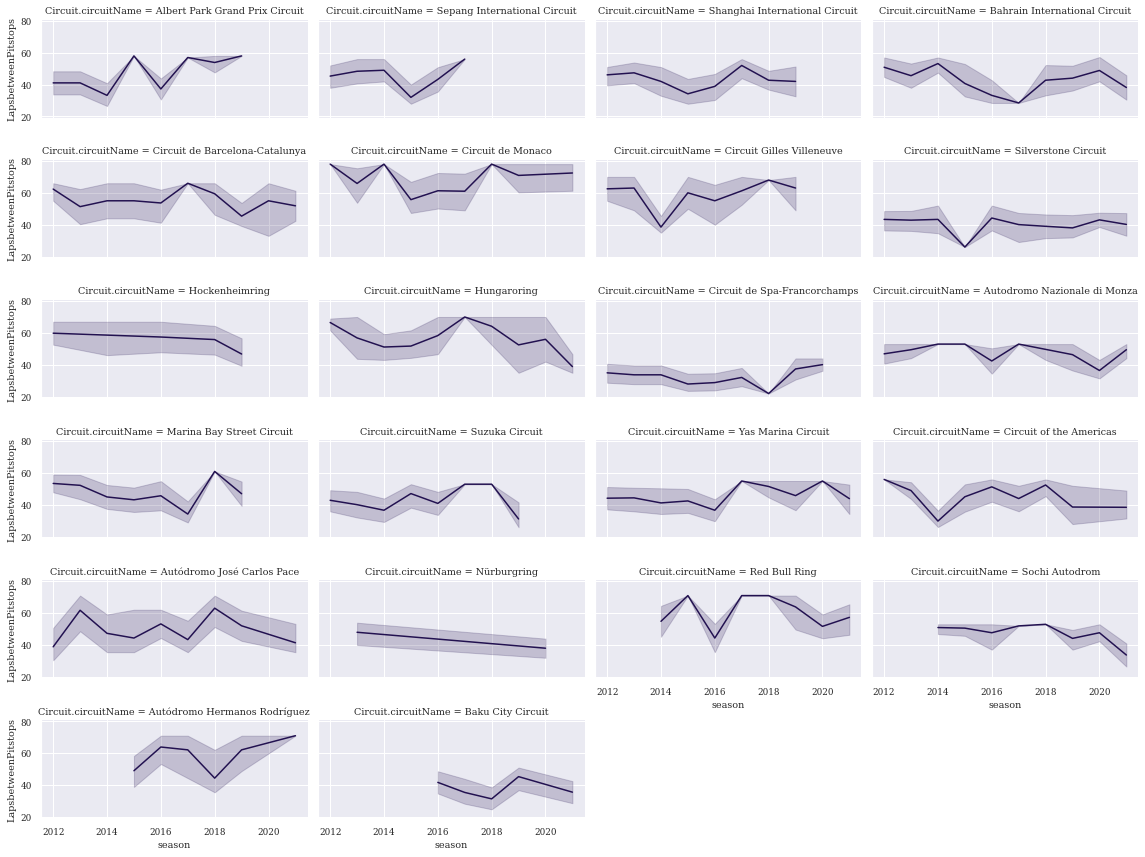

In [120]:
#Selecting specific circuits where at least two seasons a race has been helds=
SelectedCircuits=['albert_park', 'sepang', 'shanghai', 'bahrain', 'catalunya',
       'monaco', 'villeneuve', 'silverstone',
       'hockenheimring', 'hungaroring', 'spa', 'monza', 'marina_bay',
       'suzuka', 'yas_marina', 'americas',
       'interlagos', 'nurburgring', 'red_bull_ring', 'sochi', 'rodriguez',
       'BAK']

PitsUnified_Finished_Selected=PitsUnified_Finished[PitsUnified_Finished["Circuit.circuitId"].isin(SelectedCircuits) == True]

sns.set_theme(style="darkgrid", palette="magma",font_scale=0.8,font="serif")
sns.relplot(data=PitsUnified_Finished_Selected,x="season", y="LapsbetweenPitstops",col="Circuit.circuitName",col_wrap=4,kind="line",height=2,aspect=2)

### Average number of laps between pit stops

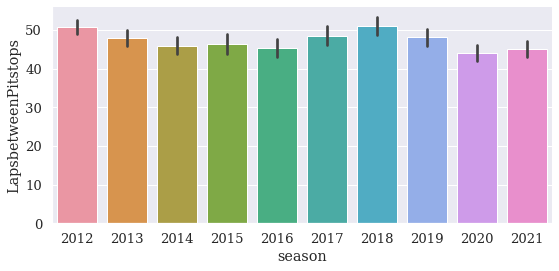

In [134]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
sns.catplot(data=PitsUnified_Finished,x="season", y="LapsbetweenPitstops",kind="bar",height=4,aspect=2)